In [1]:

import tensorflow as tf
%pip install mitdeeplearning 
import mitdeeplearning as mdl
import numpy as np
import time 
import os
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm

# assert len(tf.config.list_physical_devices('GPU'))>0


Note: you may need to restart the kernel to use updated packages.


In [31]:
# %apt-get install abcmidi timidity > /dev/null 2>&1

In [65]:
# now download the data set
songs=mdl.lab1.load_training_data()

# print one of the song and inspect the details
example_song=songs[0]
print(example_song)

Found 817 songs in text
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [64]:
# now convet into playable in system rather than abc notation
mdl.lab1.play_song(example_song)

In [5]:
# now our list of song into a single string containing all songs
songs_joined="\n\n".join(songs)

# find all unique character in the joined string
vocab=sorted(set(songs_joined))
print("there are",len(vocab),"unique characters in the dataset")

there are 83 unique characters in the dataset


now we need to crate a numerical representation of our text-based dataset
To do this, we will generate two lookup table that map charToNum and other is NumToChar


In [6]:
# define numerical representaion of text
# mapping from char to unique index
# to get index of char d 
# we need char2idx[d]
char2idx={
    u:i for i ,u in enumerate(vocab)
}

# create mapping form indices to char
# form unique indices to char in our vocb
idx2char=np.array(vocab)


In [7]:
# lets peek this numerical repersentation of our dataset
print("{")
for char,_ in zip(char2idx,range(20)):
    print('{:3s}: {:3d},'.format(repr(char),char2idx[char]))
print('....\n')    

{
'\n':   0,
' ':   1,
'!':   2,
'"':   3,
'#':   4,
"'":   5,
'(':   6,
')':   7,
',':   8,
'-':   9,
'.':  10,
'/':  11,
'0':  12,
'1':  13,
'2':  14,
'3':  15,
'4':  16,
'5':  17,
'6':  18,
'7':  19,
....



In [8]:
# now vectorize the songs string
def vectorize_string(string):
    vectorized_output=np.array([char2idx[char] for char in string])
    return vectorized_output
vectorized_songs=vectorize_string(songs_joined)

In [9]:
# now look at how the first part of the text is mapped to an integer represntaion
print('{}-----char mapped to int --->{}'.format(repr(songs_joined[:100]),vectorized_songs[:100]))
assert isinstance(vectorized_songs,np.ndarray),"return should be a numpy array"

"X:1\nT:Alexander's\nZ: id:dc-hornpipe-1\nM:C|\nL:1/8\nK:D Major\n(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe"-----char mapped to int --->[49 22 13  0 45 22 26 67 60 79 56 69 59 60 73  5 74  0 51 22  1 64 59 22
 59 58  9 63 70 73 69 71 64 71 60  9 13  0 38 22 28 82  0 37 22 13 11 20
  0 36 22 29  1 38 56 65 70 73  0  6 15 26 27 58 82 59 26 31 26  1 29 31
 26 59 82 61 59 58 59  1 31 26 59 61 82 62 61 62 60  1 61 60 61 59 82  6
 15 60 61 60]


In [10]:
# now we will break text into chunks of seq_len+1. suppose seq_lenght is 4 and out text is hello
# then out input seq is hell and target sequence ie ello
# batch definition  to creat trainning examlple
def get_batch(vectorized_songs,seq_length,batch_size):
    # length of the vectorize songs string
    n=vectorized_songs.shape[0] -1
    # randomly choose the statring indices for the examples in the training batch
    idx=np.random.choice(n-seq_length,batch_size)
    # construct a list of input squence for training batch
    input_batch=[vectorized_songs[i:i+seq_length] for i in idx]
    # construct a list of output sequecees for the training batch
    output_batch=[vectorized_songs[i+1:i+seq_length+1] for i in idx]
     
    # x_batch  and y_batch provied  the true input and target for the network of training
    x_batch=np.reshape(input_batch,[batch_size,seq_length])
    y_batch=np.reshape(output_batch,[batch_size,seq_length])
    return x_batch,y_batch
# perform some simple tests to make sure your batch fxn working properly
test_args=(vectorized_songs,10,2)
if  not mdl.lab1.test_batch_func_types(get_batch,test_args) or \
    not mdl.lab1.test_batch_func_shapes(get_batch,test_args) or \
    not mdl.lab1.test_batch_func_next_step(get_batch,test_args):
    print("=======\n[fail] could not pass the test")
else:
    print("========\n[pass] pass the test")



[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[pass] pass the test


In [11]:
x_batch,y_batch=get_batch(vectorized_songs,seq_length=5,batch_size=3)
for i,(input_idx ,target_idx) in enumerate (zip(np.squeeze(x_batch),np.squeeze(y_batch))):
    print("steps{:3d}".format(i))
    print("input:{}  ({:s})".format(input_idx,repr(idx2char[input_idx])))
    print("expected output:{} ({:s})".format(target_idx,repr(idx2char[target_idx])))

steps  0
input:[29 31 82  2  0]  (array(['D', 'F', '|', '!', '\n'], dtype='<U1'))
expected output:[31 82  2  0 30] (array(['F', '|', '!', '\n', 'E'], dtype='<U1'))
steps  1
input:[58  9 63 70 73]  (array(['c', '-', 'h', 'o', 'r'], dtype='<U1'))
expected output:[ 9 63 70 73 69] (array(['-', 'h', 'o', 'r', 'n'], dtype='<U1'))
steps  2
input:[ 1 32 14 26 82]  (array([' ', 'G', '2', 'A', '|'], dtype='<U1'))
expected output:[32 14 26 82 27] (array(['G', '2', 'A', '|', 'B'], dtype='<U1'))


now define the RNN model

In [16]:
def LSTM(rnn_units):
    return tf.keras.layers.LSTM(
        rnn_units,
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        recurrent_activation='sigmoid',
        stateful=True,
    )

In [19]:
# define rnn model 
# add LSTM and Dense layers to define the rnn model using the sequential api
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model=tf.keras.Sequential([
    # layer1: embedding layer to transform indices into dense vectors
    # of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size,embedding_dim,batch_input_shape=[batch_size,None]),
    # layer2:LSTM with `rnn_units `number of units
    # call the function defined above to add this layer.
    LSTM(rnn_units),
    # layer3: Dense (fully_connected) layer that tranform the lstm output into the vocabulary size.
    # Add the dense layer
    tf.keras.layers.Dense(vocab_size)
    ])

    return model
# build a simple model with default hyperparmeter 
# we will get the chance to change these later
model=build_model(len(vocab),embedding_dim=256,rnn_units=1024,batch_size=32)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (32, None, 256)           21248     
                                                                 
 lstm_2 (LSTM)               (32, None, 1024)          5246976   
                                                                 
 dense_2 (Dense)             (32, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [21]:
# we can quickly check the dimensionality of our output using a sequence length of 100
# note that model can run on any input length
x,y=get_batch(vectorized_songs,seq_length=100,batch_size=32)
pred=model(x)
print("input shape:",x.shape,"(bactch_size,sequence_length)")
print("prediction shape: ",pred.shape,"(batch_size,sequence_length,vocab_size)")

input shape: (32, 100) (bactch_size,sequence_length)
prediction shape:  (32, 100, 83) (batch_size,sequence_length,vocab_size)


prediction from ustained model

In [24]:
sampled_indices=tf.random.categorical(pred[0],num_samples=1)
sampled_indices=tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([68, 15, 13,  7, 55,  2, 48, 81, 81, 66, 73, 29,  0, 80, 69, 76, 46,
       19, 30, 12, 42,  8,  0,  7, 64, 72, 11, 80, 37, 63, 29, 19, 14, 33,
       31, 13, 10, 39, 15, 56, 50, 43, 30, 56, 75, 34, 23,  5, 30, 27,  1,
       55, 44, 26, 30, 64, 34, 31, 21, 26, 12, 61, 82, 64, 69, 58, 72, 49,
        9, 59, 38, 53, 75, 82,  9,  3, 14, 15, 76, 38, 33, 36, 12, 69, 74,
       55, 72, 25,  8, 15, 65, 82, 23, 37, 44, 42, 62,  5, 10, 19],
      dtype=int64)

In [27]:
# we can now decode these to see the text predicted by the untrained model:
print("input:\n",repr(" ".join(idx2char[x[0]])))
print()
print("next char pridictions :\n",repr(" ".join(idx2char[sampled_indices])))

input:
 'c A | f e d   c B A | d e f   g f g | B c B   B e d | ! \n c B A   e c A | f e d   c B A | c 2 c   d B e | A B A   A : | ! \n f g | a g f   g f e | f e d   c B A | d e f   g f g | B c B   B f g | ! \n a'

next char pridictions :
 'm 3 1 ) _ ! W z z k r D \n y n u U 7 E 0 Q , \n ) i q / y L h D 7 2 H F 1 . N 3 a Y R E a t I < \' E B   _ S A E i I F 9 A 0 f | i n c q X - d M ] t | - " 2 3 u M H K 0 n s _ q > , 3 j | < L S Q g \' . 7'


Training the model:loss and trainig operations

In [34]:
# defing the loss function
# # define the loss function to compute and return the loss between 
# #the tur lables and predictions(logits).set the argument from_logits=True
def compute_loss(labels,logits):
    loss=tf.keras.losses.sparse_categorical_crossentropy(labels,logits,from_logits=True)
    return loss
# compute the loss using the true next char form the example batch 
example_batch_loss=compute_loss(y,pred)

print("prediction shape:",pred.shape,"(batch_size,sequence_length,vocab_size)")
print("scalar_loss:",example_batch_loss.numpy().mean())

prediction shape: (32, 100, 83) (batch_size,sequence_length,vocab_size)
scalar_loss: 4.4195256


In [38]:
# hyperparmeter setting and optimization
# optimization parameters:
num_training_iteration=2000 #increase this to train longer
batch_size=4 # Experiment between 1 and 64
seq_lenght=100#experiment between 50 and 500
learning_rate=5e-3#experiment between 1e-5 and 1e-1

# model Parameter:
vocab_size=len(vocab)
embedding_dim=256
rnn_units=1024#Experiment between 1 and 1024

# checkpoint location:
Checkpoint_dir="./training_chekpoints"
Checkpoint_prefix=os.path.join(Checkpoint_dir,"my_ckpt")

In [39]:
# define optimizer and training operation
# todo: instaintiate a new model for training using the build_model
# function and the hyperparameters created above
model=build_model(vocab_size,embedding_dim,rnn_units,batch_size)
# Try using adam optimizer to start
optimizer=tf.keras.optimizers.Adam(learning_rate)
@tf.function

def train_step(x,y):
    with tf.GradientTape() as tape:
    # use gradient tape
    # todo:feed th current input to the model and generate the prediction
          y_hat=model(x)
    # compute the loss
          loss=compute_loss(y,y_hat)
    # now compute the gradient
    # we want the gradinet of the loss with respect to all the model parameter
    grads=tape.gradient(loss,model.trainable_variables)
    # apply the gradient to the optimizer so it can update the model accordingly
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    return loss 

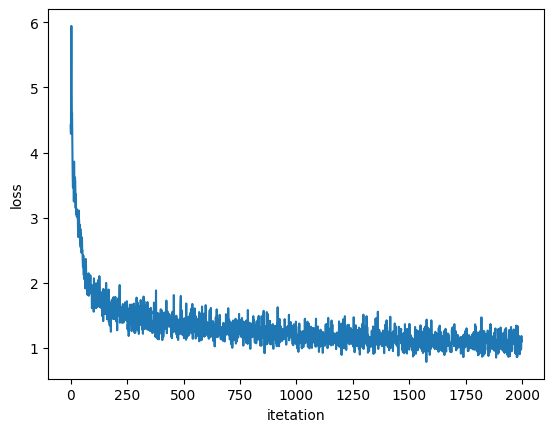

100%|██████████| 2000/2000 [55:57<00:00,  1.68s/it]


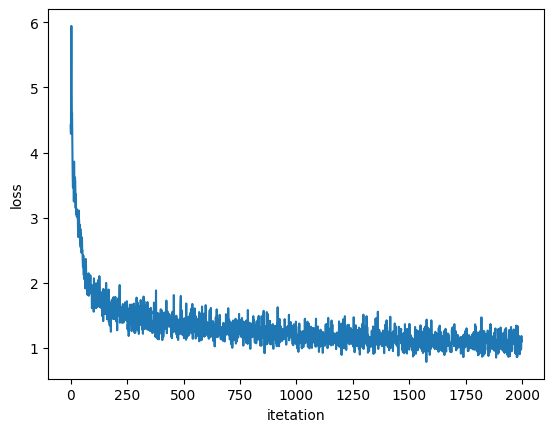

In [40]:
# Begine Training
history=[]
plotter=mdl.util.PeriodicPlotter(sec=2,xlabel="itetation",ylabel="loss")
if hasattr(tqdm,'_instances'):tqdm._instances.clear()
for iter in tqdm(range(num_training_iteration)):
    # grabe a batch and propagate through the network
    x_batch,y_batch=get_batch(vectorized_songs,seq_lenght,batch_size)
    loss=train_step(x_batch,y_batch)

    # upadate the progress bar
    history.append(loss.numpy().mean())
    plotter.plot(history)

    # update the model with changes weights
    if iter %100==0:
        model.save_weights(Checkpoint_prefix)
        
# save the trained model and the weights
model.save_weights(Checkpoint_prefix) 

In [41]:
# Rebuild the model using a batch size=1
model=build_model(vocab_size,embedding_dim,rnn_units,batch_size=1)
# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(Checkpoint_dir))
model.build(tf.TensorShape([1,None]))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (1, None, 256)            21248     
                                                                 
 lstm_5 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_5 (Dense)             (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [58]:
# prediction of a generated song
def generate_text(model,start_string,generation_length=1000):
    # evaluate step (generating ABC text using learned RNN model)
    # convert the start string to number -vectorize
    input_eval=[char2idx[s] for s in start_string]
    input_eval=tf.expand_dims(input_eval,0)
    # empty string to store out result
    text_generated=[]
    # here batch size is 1
    model.reset_states()
    tqdm._instances.clear()

    for i in tqdm(range(generation_length)):
        # evaluate the inputs and generate the next character predictions
        predictions=model(input_eval)
        # remove the batch dimension
        predictions=tf.squeeze(predictions,0)
        # use multinomial distribution to to sample
        predicted_id=tf.random.categorical(predictions,num_samples=1)[-1,0].numpy()
        # pass the prediction along wiht the previous hidden state
        # as the next input to the model
        input_eval=tf.expand_dims([predicted_id], 0)
        # pass the prediction along with the previous hidden state
        text_generated.append(idx2char[predicted_id])
    return (start_string+''.join(text_generated))    

                          

In [59]:
# use the above function to generate the ABC formate text of length 1000
generated_text=generate_text(model,start_string="X",generation_length=1000)


100%|██████████| 1000/1000 [00:13<00:00, 72.36it/s]


In [63]:
# play back generated songs
generated_song=mdl.lab1.extract_song_snippet(generated_text)
for i,song in enumerate(generated_song):
    # synthesize the waveform form a song
    waveform=mdl.lab1.play_song(song)
    # if its a valid song (correct syntax),lets play it!
    if waveform:
        print("generated song",i)
        ipythondisplay.display(waveform)

Found 3 songs in text
